In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./AirPassengers.csv').rename(columns={'Month': 'Date', '#Passengers': 'Values'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    144 non-null    object
 1   Values  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Values
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
df_nixtla = pd.DataFrame({
    'ds': df.Date.values,
    'y': df.Values.values,
    'unique_id': 'series01'
})

df_nixtla

,ds,y,unique_id
0,1949-01-01,112,series01
1,1949-02-01,118,series01
2,1949-03-01,132,series01
3,1949-04-01,129,series01
4,1949-05-01,121,series01
...,...,...,...
139,1960-08-01,606,series01
140,1960-09-01,508,series01
141,1960-10-01,461,series01
142,1960-11-01,390,series01


In [5]:
test_size = int(df.shape[0] * 0.1)

In [6]:
test = df_nixtla.tail(test_size)
train = df_nixtla.drop(test.index)

In [7]:
test

,ds,y,unique_id
130,1959-11-01,362,series01
131,1959-12-01,405,series01
132,1960-01-01,417,series01
133,1960-02-01,391,series01
134,1960-03-01,419,series01
135,1960-04-01,461,series01
136,1960-05-01,472,series01
137,1960-06-01,535,series01
138,1960-07-01,622,series01
139,1960-08-01,606,series01


In [8]:
train

,ds,y,unique_id
0,1949-01-01,112,series01
1,1949-02-01,118,series01
2,1949-03-01,132,series01
3,1949-04-01,129,series01
4,1949-05-01,121,series01
...,...,...,...
125,1959-06-01,472,series01
126,1959-07-01,548,series01
127,1959-08-01,559,series01
128,1959-09-01,463,series01


In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

In [10]:
models = [
    KNeighborsRegressor(n_neighbors=3, weights='distance'),
    DecisionTreeRegressor(criterion='friedman_mse', max_depth=5)
]

In [11]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences

In [12]:
fcst = MLForecast(
    models=models,
    freq='ME',
    lags=[1, 12],
    target_transforms=[Differences([2])]
)

In [13]:
fcst.fit(train)

MLForecast(models=[KNeighborsRegressor, DecisionTreeRegressor], freq=ME, lag_features=['lag1', 'lag12'], date_features=[], num_threads=1)

In [14]:
predict_full = fcst.predict(test.shape[0])
predict_full

,unique_id,ds,KNeighborsRegressor,DecisionTreeRegressor
0,series01,1959-10-31,369.162109,369.000000
1,series01,1959-11-30,392.469269,380.000000
2,series01,1959-12-31,399.126465,403.096771
3,series01,1960-01-31,401.143738,384.545441
4,series01,1960-02-29,436.043671,437.193542
5,series01,1960-03-31,455.199432,418.642212
6,series01,1960-04-30,451.922699,452.493530
7,series01,1960-05-31,534.411987,500.142212
8,series01,1960-06-30,578.548950,580.493530
9,series01,1960-07-31,626.114990,587.142212


In [15]:
predict_full = predict_full.reset_index()

In [16]:
series = []
for unique_id in predict_full['unique_id'].unique():
  serie = predict_full.query("unique_id == @unique_id ")[['KNeighborsRegressor', 'DecisionTreeRegressor']]
  series.append(serie)

In [17]:
series

[    KNeighborsRegressor  DecisionTreeRegressor
 0            369.162109             369.000000
 1            392.469269             380.000000
 2            399.126465             403.096771
 3            401.143738             384.545441
 4            436.043671             437.193542
 5            455.199432             418.642212
 6            451.922699             452.493530
 7            534.411987             500.142212
 8            578.548950             580.493530
 9            626.114990             587.142212
 10           495.111816             491.160187
 11           477.654755             435.142212
 12           401.212708             397.160187
 13           460.106842             378.142212]

In [18]:
df_result = series[0]
df_result['target'] = test['y'].values[:test.shape[0]]

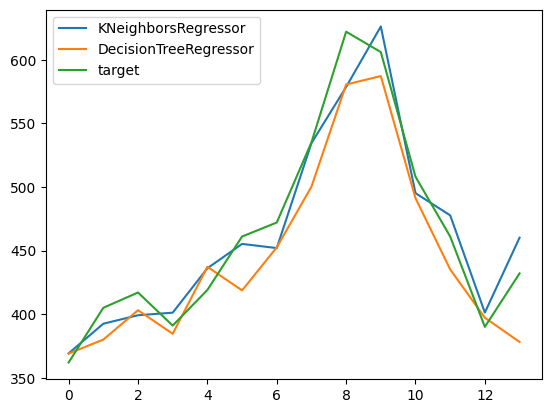

In [19]:
df_result.plot();